# Business Understanding:
#### TechInvest Holdings wants to predict the future price of the NASDAQ to better position themselves in the tech stock field.  They have tasked me with creating a time series model to predict future prices of the NASDAQ to make informed investing decisions.  TechInvest would like to forecast the next seven days.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Data Understanding
####  The code loads the historical data from a CSV file and creates a Pandas dataframe. The dataframe contains columns for the date, closing price, and volume. It then plots the volume and closing price data to visualize the trends. The data is split into training and testing sets and scaled using MinMaxScaler.

In [2]:
# load data
df = pd.read_csv('ndaq_stock_data.csv')
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-07-01 00:00:00-04:00,4.192588,4.192588,4.192588,4.192588,3900,0.0,0.0
1,2002-07-02 00:00:00-04:00,4.332342,4.611848,4.192589,4.228925,21000,0.0,0.0
2,2002-07-03 00:00:00-04:00,3.913083,4.472094,3.913083,4.192588,30600,0.0,0.0
3,2002-07-05 00:00:00-04:00,4.192588,4.192588,4.192588,4.192588,1500,0.0,0.0
4,2002-07-08 00:00:00-04:00,3.913082,3.913082,3.913082,3.913082,900,0.0,0.0
...,...,...,...,...,...,...,...,...
4653,2020-12-22 00:00:00-05:00,41.285344,42.374107,41.191091,42.218105,3123300,0.0,0.0
4654,2020-12-23 00:00:00-05:00,42.409853,42.491106,41.581092,41.584343,1479300,0.0,0.0
4655,2020-12-24 00:00:00-05:00,41.594095,41.841099,41.467342,41.802097,575400,0.0,0.0
4656,2020-12-28 00:00:00-05:00,41.951602,41.997102,41.574594,41.876850,1376100,0.0,0.0


###  We will not be using the dividend and split columns, as our focus is on forecasting using the closing price and the daily volume.  We  will use the Date column as our index.  

### The volume can indicate the demand or liquidity, both of which are important for decision making.  The closing price reflects the overall sentiment of trading at the end of the day.


In [3]:
df['Date'] = df['Date'].str[:10]
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [4]:
# Remove timestamp from date column
df['Date'] = pd.to_datetime(df['Date']).dt.date

In [5]:
# Use only Close and Volume columns as predictors
df = df[['Date', 'Close', 'Volume']].set_index('Date')

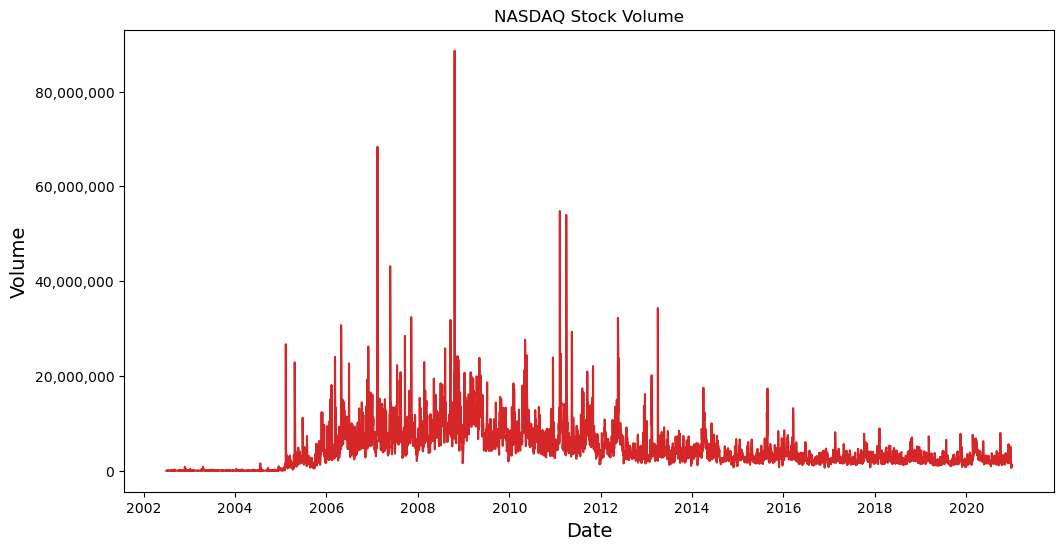

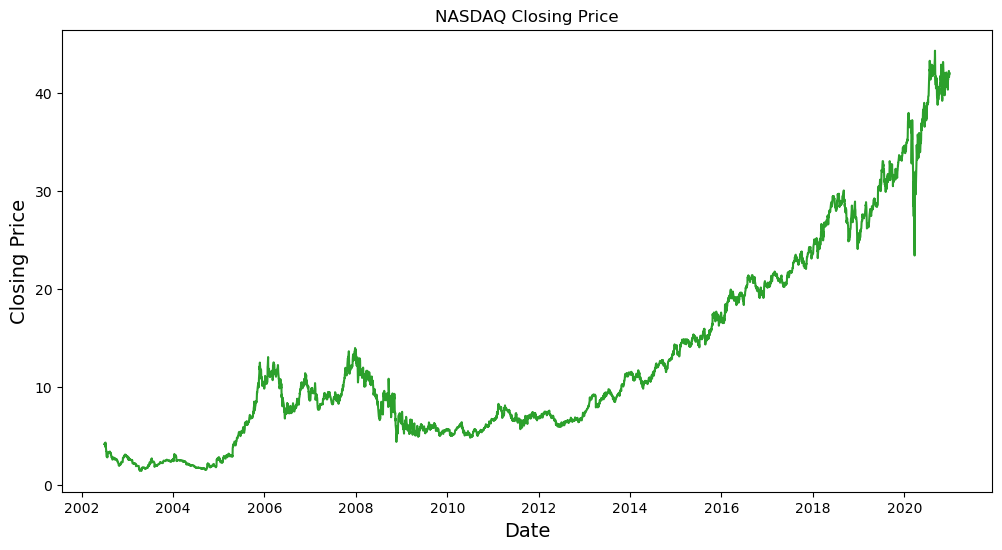

In [6]:
# Plot volume data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, df['Volume'], color = 'tab:red')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Volume', fontsize=14)
ax.set_title('NASDAQ Stock Volume')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.show()

# Plot closing price data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, df['Close'], color = 'tab:green')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Closing Price', fontsize=14)
ax.set_title('NASDAQ Closing Price')
plt.show()

In [7]:
# Split data into training, validation, and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)
train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=False)

In [8]:
# Scale data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['Close', 'Volume']])
val_scaled = scaler.transform(val_data[['Close', 'Volume']])
test_scaled = scaler.transform(test_data[['Close', 'Volume']])

## Data Preparation:
#### The code creates sliding window data for the training and testing sets using a window size of 30 days. It then creates an LSTM model using Keras and trains it on the training data. After training the model, it creates sliding window data for the testing set and uses the trained model to predict the closing prices. 

In [9]:
# Create sliding window data for training set.
window_size = 30
X_train = []
y_train = []

for i in range(window_size, len(train_scaled)):
    X_train.append(train_scaled[i-window_size:i, :])
    y_train.append(train_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [10]:
# Create sliding window data for validation set
# inspired by tutorial at https://www.tensorflow.org/tutorials/structured_data/time_series#convolution_neural_network
X_val = []
y_val = []

for i in range(window_size, len(val_scaled)):
    X_val.append(val_scaled[i-window_size:i, :])
    y_val.append(val_scaled[i, 0])

X_val, y_val = np.array(X_val), np.array(y_val)

## Modeling:
#### The code creates an LSTM model with one LSTM layer and one Dense layer. It uses the mean squared error (MSE) as the loss function and the Adam optimizer. It trains the model for 50 epochs with a batch size of 32.

#### This model does not explicitly take into account seasonality. However, it does use a sliding window approach to create input sequences for the LSTM model, which can help capture patterns in the data over time. Additionally, the use of the train_test_split function helps to ensure that the model is evaluated on unseen data, which can help to prevent overfitting and improve generalization.

In [11]:
# Create LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

In [12]:
# Define callbacks
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [13]:
# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, shuffle=False,
callbacks=[model_checkpoint], validation_data=(X_val, y_val))

Epoch 1/50
93/93 [==============================] - 5s 59ms/step - loss: 0.0091 - root_mean_squared_error: 0.0952 - val_loss: 0.0558 - val_root_mean_squared_error: 0.2361
Epoch 2/50
93/93 [==============================] - 4s 46ms/step - loss: 0.0046 - root_mean_squared_error: 0.0676 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1430
Epoch 3/50
93/93 [==============================] - 4s 45ms/step - loss: 0.0012 - root_mean_squared_error: 0.0353 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1503
Epoch 4/50
93/93 [==============================] - 4s 46ms/step - loss: 0.0017 - root_mean_squared_error: 0.0408 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1396
Epoch 5/50
93/93 [==============================] - 4s 46ms/step - loss: 0.0016 - root_mean_squared_error: 0.0394 - val_loss: 0.0164 - val_root_mean_squared_error: 0.1281
Epoch 6/50
93/93 [==============================] - 4s 46ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0157 - val_root_m

## Evaluation:
#### The code evaluates the performance of the model using the RMSE of the predicted closing prices and the actual closing prices for the testing set. It also plots the predicted and actual closing prices for the testing set.

In [14]:
# Create sliding window data for testing set
X_test = []
y_test = []

for i in range(window_size, len(test_scaled)):
    X_test.append(test_scaled[i-window_size:i, :])
    y_test.append(test_scaled[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [15]:
print(test_data)

                Close   Volume
Date                          
2017-04-19  20.956850  1465800
2017-04-20  21.244678  2055000
2017-04-21  21.181057  2500800
2017-04-24  21.344660  3351600
2017-04-25  21.368898  2281500
...               ...      ...
2020-12-22  42.218105  3123300
2020-12-23  41.584343  1479300
2020-12-24  41.802097   575400
2020-12-28  41.876850  1376100
2020-12-29  41.971100   910800

[932 rows x 2 columns]


In [16]:
# Make predictions
y_pred = model.predict(X_test)

In [17]:
# Inverse transform scaled data to get actual values
y_pred = scaler.inverse_transform(np.concatenate((y_pred, test_data[window_size:][['Volume']]), axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), test_data[window_size:][['Volume']]), axis=1))[:, 0]

In [18]:
# Calculate root mean squared error (RMSE)
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
print('Test RMSE:', rmse)

Test RMSE: 0.9277752021032534


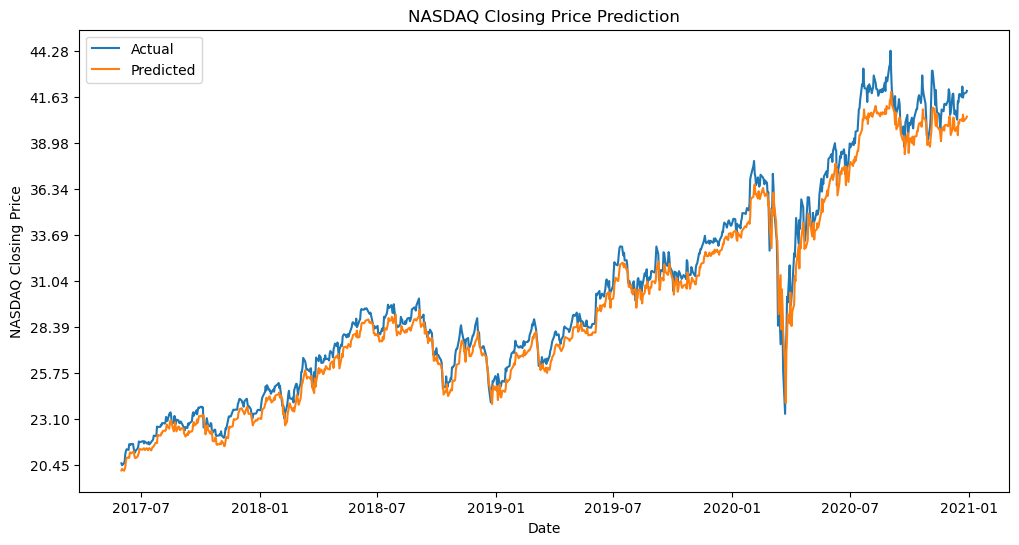

In [19]:
# Plot actual and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(test_data[window_size:].reset_index()['Date'], y_test, label='Actual')
plt.plot(test_data[window_size:].reset_index()['Date'], y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('NASDAQ Closing Price')
plt.title('NASDAQ Closing Price Prediction')
plt.legend()
num_ticks = 10
yticks = np.linspace(min(y_test), max(y_test), num_ticks)
plt.yticks(yticks)
plt.show()

## Deployment:
#### The code uses the trained model to predict the closing prices for the next 7 days. It creates a range of dates for the next 7 days and uses the predicted closing prices to plot a graph of the predicted closing prices for the next 7 days.

In [20]:
# Define the number of days to predict
n_days = 7

In [21]:
# Get the last window_size data points from the original dataset
last_data_points = df.tail(window_size)

In [22]:
# Scale the input data
input_data = scaler.transform(last_data_points[['Close', 'Volume']])

In [23]:
# Make predictions for the next n_days
predicted_prices = []
for i in range(n_days):
    # Reshape the input data to match the model's expected input shape
    input_data_reshaped = np.reshape(input_data, (1, window_size, 2))
    
    # Use the model to predict the next day's closing price
    next_day_predicted_price = model.predict(input_data_reshaped)[0][0]
    
    # Inverse transform the predicted price to get the actual value
    next_day_predicted_price = scaler.inverse_transform([[next_day_predicted_price, 0]])[0][0]
    
    # Add the predicted price to the list of predicted prices
    predicted_prices.append(next_day_predicted_price)
    
    # Add the predicted price to the input data and remove the oldest value
    input_data = np.append(input_data, [[next_day_predicted_price, 0]], axis=0)[1:]

In [24]:
# Create a range of dates for the next n_days
dates = pd.date_range(df.index[-1], periods=n_days+1, freq='D')[1:]

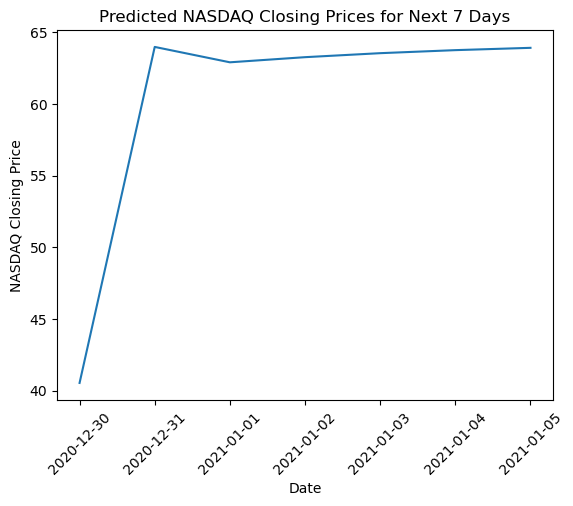

In [25]:
# Plot the predicted prices
plt.plot(dates, predicted_prices)
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('NASDAQ Closing Price')

plt.title('Predicted NASDAQ Closing Prices for Next ' + str(n_days) + ' Days')
plt.show()


## Conclusion
#### The model has shown a good RMSE based on the models performance.  The models predictions follow the actual trends quite well, without overfitting.  However, stock market model predictions based on only a few variables can only tell so much.  Given the influences of public sentiment, governmental policies, and unforeseen events, this model takes into account only the factors that have been given it;  the closing price and traded volume within the historical data.

## Further Actions
#### Further actions that would make this model more accurate would be to incorporate mechanisms that allow the data to be scraped and incorporated such as public sentiment (e.g., twitter analysis, proposed legislation, and other current economic factors).